In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

In [2]:
# This converter function will convert the string into corresponding value.
#def converter1(x):
#    if x == b'A' or x == b'B' or x == b'C' or x == b'D' or x == b'E' or x == b'F' or x == b'G' or x == b'H' or x == b'I' or x == b'J' or x == b'K' or x == b'L' or x == b'M':       
#        return 1
#    else:
#        return 0
def converter1(x):
    if ord(x)-ord(b'M') > 0:
        return 0
    else:
        return 1

In [3]:
column1 = 0

data = np.loadtxt('letter-recognition.data', delimiter=',', 
               converters={column1:converter1})

In [4]:
print(data)
print(data.shape)

[[  0.   2.   8. ...,   8.   0.   8.]
 [  1.   5.  12. ...,   8.   4.  10.]
 [  1.   4.  11. ...,   7.   3.   9.]
 ..., 
 [  0.   6.   9. ...,  12.   2.   4.]
 [  0.   2.   3. ...,   9.   5.   8.]
 [  1.   4.   9. ...,   7.   2.   8.]]
(20000, 17)


In [5]:
# Divide data into training and testing sets
X_and_Y = data
np.random.shuffle(X_and_Y)

# Try to predict the last column (the cover type, which is 7 types)
X = X_and_Y[:5000,1:17]
Y = X_and_Y[:5000,0]
print(X.shape, Y.shape)

(5000, 16) (5000,)


In [6]:
X_train_val = X[:int(0.8*len(X))]
X_test      = X[int(0.8*len(X)):]
Y_train_val = Y[:int(0.8*len(Y))]
Y_test      = Y[int(0.8*len(Y)):]
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(4000, 16) (1000, 16) (4000,) (1000,)


In [7]:
# SVM process

# linear
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='linear')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]   
params = {"C": C_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([  4.36346292e-01,   4.95149612e-01,   4.81077290e-01,
          4.36314964e-01,   3.95520687e-01,   3.55202150e-01,
          6.22439480e-01,   2.08230133e+00,   1.30436397e+01,
          8.75597998e+01,   7.55478187e+02]),
 'mean_score_time': array([ 0.06274753,  0.06484776,  0.05664077,  0.05403876,  0.04403181,
         0.03522534,  0.04013257,  0.0365263 ,  0.04523182,  0.04373889,
         0.03612638]),
 'mean_test_score': array([ 0.50025,  0.50025,  0.50025,  0.679  ,  0.71   ,  0.71975,
         0.7205 ,  0.7215 ,  0.72225,  0.72225,  0.72225]),
 'mean_train_score': array([ 0.50025   ,  0.50025   ,  0.50025   ,  0.67781311,  0.71362538,
         0.72587528,  0.72618778,  0.72587526,  0.72606276,  0.72618776,
         0.72600026]),
 'param_C': masked_array(data = [1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1.0 10.0 100.0 1000.0],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'params': ({'C

In [8]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 10.0}
0.74


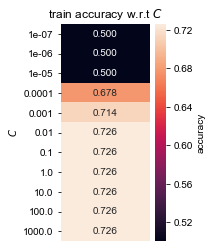

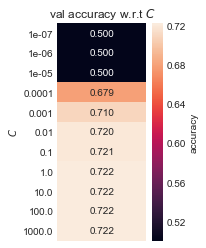

In [9]:
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
results = GSR.cv_results_

train_acc = np.matrix(results.get("mean_train_score")).T
draw_heatmap_linear(train_acc, 'train accuracy', C_list)

val_acc = np.matrix(results.get("mean_test_score")).T
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

In [10]:
def convert_to_gamma(radial_width):
    converted = [0]*len(radial_width)
    for i in range(len(radial_width)):
        gamma = 1/(2*(radial_width[i]**2))
        converted[i] = gamma
    return converted

radial_width = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
gamma_list = convert_to_gamma(radial_width)

# SVM process

# rbf
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='rbf')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]
params = {"C": C_list, "gamma": gamma_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([ 0.93458047,  0.98542342,  0.92824702,  0.95387979,  0.81997933,
         2.33318605,  1.48626819,  0.67410073,  0.91307478,  0.98805885,
         1.03817158,  0.90740838,  0.95767732,  2.45619106,  1.52460871,
         0.74030104,  1.04759464,  1.05311866,  1.03788242,  1.00704417,
         1.00394692,  2.39224272,  1.46803508,  0.72649565,  1.04717345,
         1.01292768,  0.86141195,  0.80536957,  0.82047973,  2.26320138,
         1.39318643,  0.59792261,  0.79386158,  0.81948066,  0.78605843,
         0.81257958,  0.83935752,  2.28903203,  1.38548369,  0.61073565,
         0.85721569,  0.93626862,  0.8280921 ,  0.76584411,  0.81547627,
         2.28751993,  1.38978925,  0.59211802,  0.82960224,  0.81508336,
         0.80828686,  0.79496188,  0.79427214,  2.27472715,  1.3828845 ,
         0.57650905,  0.83889866,  0.80277443,  1.02954354,  1.18475118,
         1.00647168,  2.65497317,  1.74961843,  0.86585808,  0.95833559,
         0.92158971,  1.0504271 , 

In [11]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 10.0, 'gamma': 0.125}
0.954


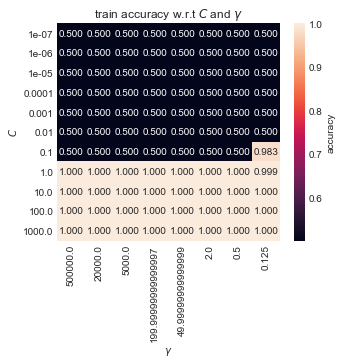

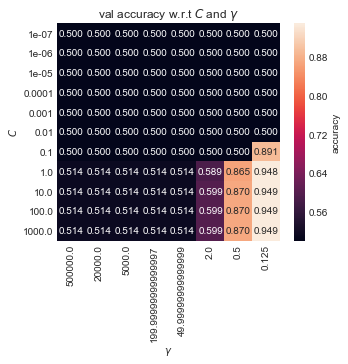

In [12]:
def draw_heatmap_RBF(acc, acc_desc, gamma_list, C_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$ and $\gamma$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()   

train_acc = GSR.cv_results_['mean_train_score'].reshape(11,8)
draw_heatmap_RBF(train_acc, 'train accuracy', gamma_list, C_list)

val_acc = GSR.cv_results_['mean_test_score'].reshape(11,8)
draw_heatmap_RBF(val_acc, 'val accuracy',gamma_list, C_list)

In [13]:
# KNN
k_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#k_list = [1,5,8]
params = {"n_neighbors": k_list}
knn = KNeighborsClassifier(n_neighbors=26)
kgs=GridSearchCV(knn, params)
knn.fit(X_train_val, Y_train_val)
knn.predict(X_test)

array([ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,
        0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,
        0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0

In [14]:
# compute accuracy
test_acc = np.sum(knn.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.88


In [15]:
# Random Forest
rf = RandomForestClassifier(n_estimators=1024, random_state=0)
rf.fit(X_train_val, Y_train_val)
rf.predict(X_test)

array([ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,
        0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
        1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,
        0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,
        1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0

In [16]:
# compute accuracy
test_acc = np.sum(rf.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.945
